In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_log_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tabulate import tabulate
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [19]:
df=pd.read_csv('KepRiau 2015 - 2022.csv')
df

,datetime,total_visitor,total_accomodation
0,1/1/2014,164430,10055
1,2/1/2014,137055,10079
2,3/1/2014,167030,10132
3,4/1/2014,151982,10190
4,5/1/2014,154299,10274
...,...,...,...
103,8/1/2022,79470,15449
104,9/1/2022,104652,15502
105,10/1/2022,106160,15525
106,11/1/2022,103940,15612


In [20]:
train_datetime=pd.to_datetime(df['datetime'])
train_datetime

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]

In [21]:
selected_columns = ['total_visitor','total_accomodation']
data_train = df.loc[:, selected_columns].astype(float)

In [22]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_train)

In [23]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]
    
    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)

TEST SIZE 80:20

In [24]:
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 12, 2)
(76, 1)
(20, 12, 2)
(20, 1)


In [26]:
model=Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1]))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4288      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4353 (17.00 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
history=model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100

3/3 [==============================] - 2s 16ms/step - loss: 0.1491
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0835
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0322
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0314
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0204
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 8/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0190
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 11/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0157
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 13/100
3/3 [==============================] - 0s 8

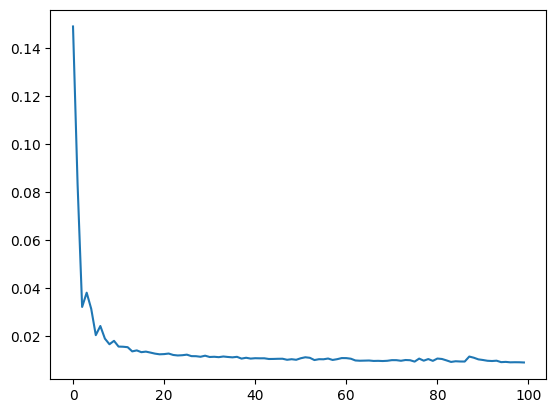

In [30]:
plt.plot(history.history['loss'])

In [31]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [32]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 309ms/step
mse: 0.006914881472173423
rmse 0.08315576631944067
MAPE: 4.84%
mae 0.0625386389616278


In [33]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_15612\1499544800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\atrke\AppD

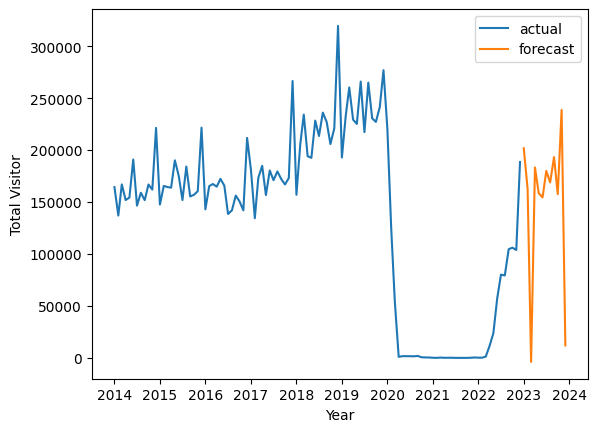

In [34]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [35]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │    201838    │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │    162583    │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     -3739.66 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │    183336    │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │    158639    │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │    154533    │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │    179990    │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │    168899    │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │    193264    │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │    157638    │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │    238657    │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  